In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from vega_datasets import data

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pymc3     : 3.9.3
pandas    : 1.1.3
numpy     : 1.19.2
theano    : 1.0.5
matplotlib: 3.3.2
arviz     : 0.10.0
seaborn   : 0.11.0
sklearn   : 0.23.2



This is a modified version of the [Poisson GLM example](https://docs.pymc.io/notebooks/GLM-poisson-regression.html) from pymc gallery.

### Data

In [14]:

# decide poisson theta values
theta_noalcohol_meds = 1    # no alcohol, took an antihist
theta_alcohol_meds = 3      # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36   # alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_noalcohol_meds, q),
                                   np.random.poisson(theta_alcohol_meds, q),
                                   np.random.poisson(theta_noalcohol_nomeds, q),
                                   np.random.poisson(theta_alcohol_nomeds, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})
df.head()

,nsneeze,alcohol,nomeds
0,6,False,False
1,0,False,False
2,0,False,False
3,1,False,False
4,1,False,False


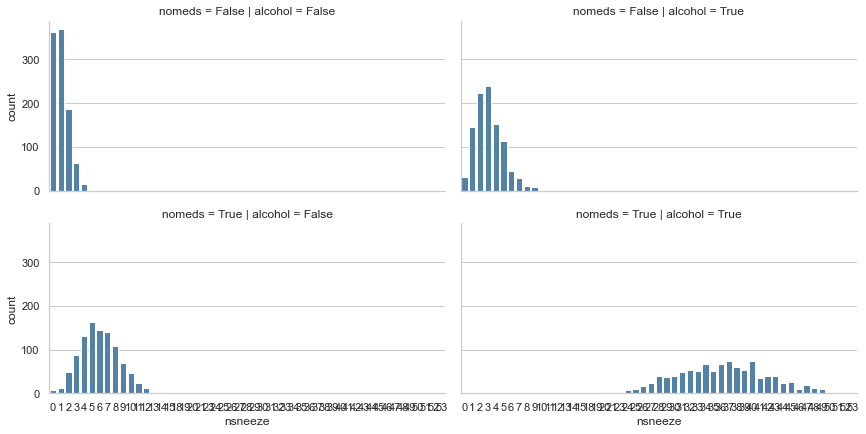

In [15]:
sns.catplot(kind='count', data=df, 
            x='nsneeze', col='alcohol', row='nomeds',
            aspect=2, height=3, color='steelblue')

In [16]:
df[['alcohol','nomeds']] = df[['alcohol','nomeds']].astype(int)
df['both'] = df['alcohol'] * df['nomeds']

### Effect of interaction term in Poisson GLM

In [21]:
def interaction_model_factory(x_in, y_in):
    with pm.Model() as model:
        # data
        alcohol = pm.Data('alcohol', x_in['alcohol'])
        nomeds = pm.Data('nomeds', x_in['nomeds'])
        both = pm.Data('both', x_in['both'])
        nsneezes = pm.Data('nsneezes', y_in)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β_alcohol = pm.Normal('β_alcohol', 0, 1)
        β_nomeds = pm.Normal('β_nomeds', 0, 1)
        β_both = pm.Normal('β_both', 0, 1)

        # model
        θ = pm.Deterministic('θ', pm.math.exp(alcohol * β_alcohol + nomeds * β_nomeds + both * β_both + α)) 
        y_hat = pm.Poisson('y_hat', mu=θ, observed=nsneezes)
    return model

def nointeraction_model_factory(x_in, y_in):
    with pm.Model() as model:
        # data
        alcohol = pm.Data('alcohol', x_in['alcohol'])
        nomeds = pm.Data('nomeds', x_in['nomeds'])
        nsneezes = pm.Data('nsneezes', y_in)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β_alcohol = pm.Normal('β_alcohol', 0, 1)
        β_nomeds = pm.Normal('β_nomeds', 0, 1)

        # model
        θ = pm.Deterministic('θ', pm.math.exp(alcohol * β_alcohol + nomeds * β_nomeds + α)) 
        y_hat = pm.Poisson('y_hat', mu=θ, observed=nsneezes)
    return model

In [22]:
interaction_model = interaction_model_factory(df[['alcohol','nomeds','both']], df['nsneeze'])
interaction_model

In [30]:
with interaction_model:
    # Prior sampling, trace definition and posterior sampling
    interaction_model_prior = pm.sample_prior_predictive()
    interaction_model_posterior = pm.sample(tune=1500)
    interaction_model_posterior_pred = pm.sample_posterior_predictive(interaction_model_posterior)
interaction_model_inf_obj = az.from_pymc3(prior=interaction_model_prior, trace=interaction_model_posterior, posterior_predictive=interaction_model_posterior_pred,
                                          model=interaction_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_both, β_nomeds, β_alcohol, α]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 76 seconds.
The number of effective samples is smaller than 25% for some parameters.


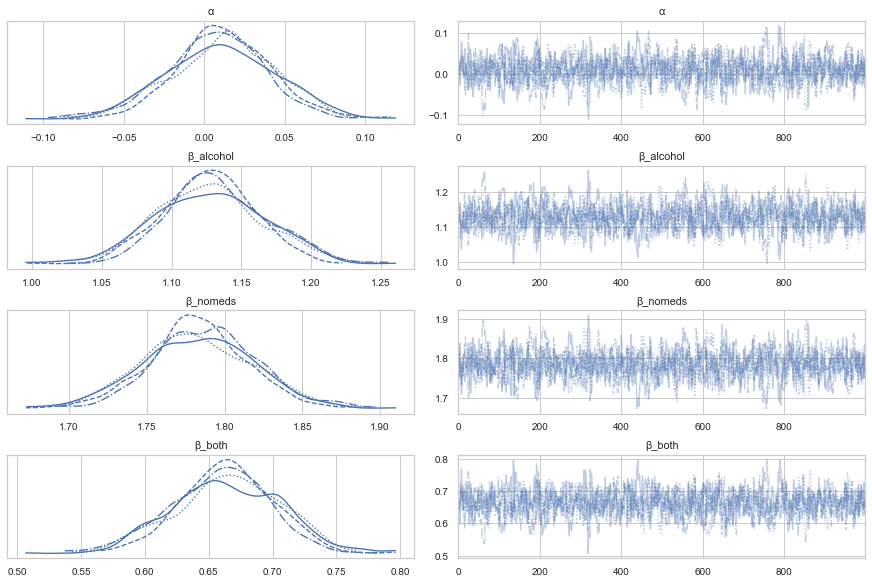

In [31]:
pm.traceplot(interaction_model_inf_obj, var_names=['~θ']);

In [24]:
nointeraction_model = nointeraction_model_factory(df[['alcohol','nomeds']], df['nsneeze'])
nointeraction_model

In [25]:
with nointeraction_model:
    # Prior sampling, trace definition and posterior sampling
    nointeraction_model_prior = pm.sample_prior_predictive()
    nointeraction_model_posterior = pm.sample()
    nointeraction_model_posterior_pred = pm.sample_posterior_predictive(nointeraction_model_posterior)
nointeraction_model_inf_obj = az.from_pymc3(prior=nointeraction_model_prior, trace=nointeraction_model_posterior, posterior_predictive=nointeraction_model_posterior_pred,
                                            model=nointeraction_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_nomeds, β_alcohol, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


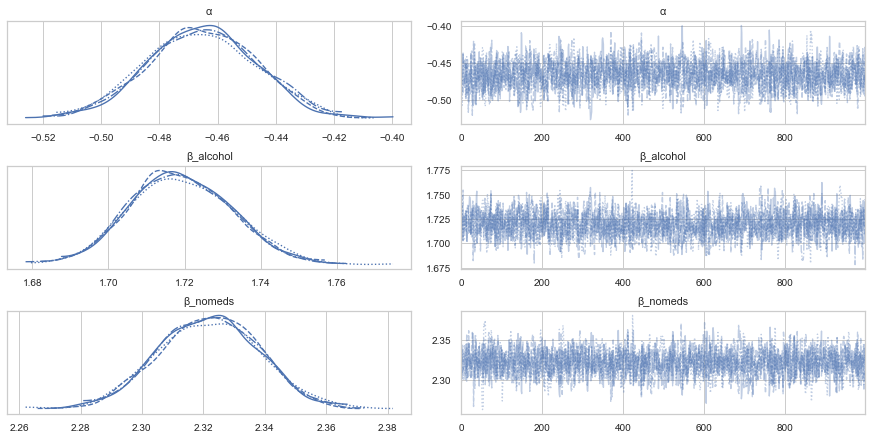

In [29]:
pm.traceplot(nointeraction_model_inf_obj, var_names=['~θ']);

In [33]:
az.summary(interaction_model_inf_obj, var_names=['~θ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.010,0.032,-0.050,0.070,0.001,0.001,745.0,578.0,752.0,815.0,1.01
β_alcohol,1.129,0.037,1.063,1.199,0.001,0.001,742.0,736.0,746.0,673.0,1.01
β_nomeds,1.784,0.034,1.719,1.849,0.001,0.001,753.0,751.0,757.0,778.0,1.01
β_both,0.663,0.040,0.588,0.733,0.001,0.001,753.0,753.0,755.0,802.0,1.01


In [34]:
az.summary(nointeraction_model_inf_obj, var_names=['~θ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.465,0.019,-0.502,-0.431,0.0,0.0,1682.0,1674.0,1679.0,1744.0,1.0
β_alcohol,1.719,0.013,1.695,1.744,0.0,0.0,1607.0,1607.0,1587.0,1760.0,1.0
β_nomeds,2.322,0.016,2.292,2.353,0.0,0.0,1950.0,1950.0,1945.0,1878.0,1.0


### Using patsy formula and `pymc.GLM` families

In [94]:
def formula_model_factory(data_df):
    with pm.Model() as model:
        # priors on parameters
        priors = {
            'Intercept': pm.Normal('α', 0, 1),
            'Regressor': pm.Normal('β', 0, 1)
        }
        
        # model specification
        pm.glm.GLM.from_formula('nsneeze ~ alcohol + nomeds + alcohol * nomeds',
                                data=data_df,
                                priors=priors,
                                family=pm.glm.families.Poisson())

    return model

In [53]:
df[['nsneeze_z']] = StandardScaler().fit_transform(df[['nsneeze']])

In [95]:
formula_model = formula_model_factory(df[['nsneeze','alcohol','nomeds']])
formula_model

TypeError: prod() got an unexpected keyword argument 'out'

In [ ]:
with formula_model:
    # Prior sampling, trace definition and posterior sampling
    formula_model_prior = pm.sample_prior_predictive()
    formula_model_posterior = pm.sample()
    formula_model_posterior_pred = pm.sample_posterior_predictive(formula_model_posterior)
formula_model_inf_obj = az.from_pymc3(prior=formula_model_prior, trace=formula_model_posterior, posterior_predictive=formula_model_posterior_pred,
                                      model=formula_model)

In [ ]:
pm.traceplot(nointeraction_model_inf_obj, var_names=['~θ']);

In [ ]:
az.summary(interaction_model_inf_obj, var_names=['~θ'])